In [263]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [264]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    #good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [265]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [266]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [267]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [268]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift Purity:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [269]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [270]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [274]:
#dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname ='BGS_80613_Cascades_subsamples.fits'
#dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
#dir = '/Users/tlan/Desktop/'


SV_depth_catalog = pf.getdata(dir+dataname,1)

#SV_depth_catalog = Table.read(dir+dataname)
#SV_depth_catalog['DELTACHI2_cas']=SV_depth_catalog['DELTACHI2']
#SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['N_VI']>0) & (SV_depth_catalog['subset']=='subset-4')]
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['subset_id']<=2)]
SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['zwarn_cas']<=4)]#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>15)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>15')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>30')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>15) & (SV_depth_catalog['Z']<0.9) & (SV_depth_catalog['DELTACHI2_cas']<10000000)]# & (np.array(flux_to_mag(SV_depth_catalog)['z'])<24)]# & (SV_depth_catalog['FIBERFLUX_R']>1)]
print('DELTACHI2_cas>15 & Redrock_z<0.9')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30) & (SV_depth_catalog['Z']<0.9)]
print('DELTACHI2_cas>30 & Redrock_z<0.9')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift Purity: 0.9216335540838853
Good data completeness: 1.0
Combined value: 0.9216335540838853
--------
DELTACHI2_cas>15
Redshift Purity: 0.9663620454987362
Good data completeness: 0.9920159680638723
Combined value: 0.9586465800656125
--------
DELTACHI2_cas>30
Redshift Purity: 0.9748115827052757
Good data completeness: 0.9810379241516967
Combined value: 0.9563271315362136
--------
DELTACHI2_cas>15 & Redrock_z<0.9
Redshift Purity: 0.9926088693567718
Good data completeness: 0.9918163672654691
Combined value: 0.9844857229209181
--------
DELTACHI2_cas>30 & Redrock_z<0.9
Redshift Purity: 0.9923263327948304
Good data completeness: 0.9808383233532935
Combined value: 0.9733116964778038


81


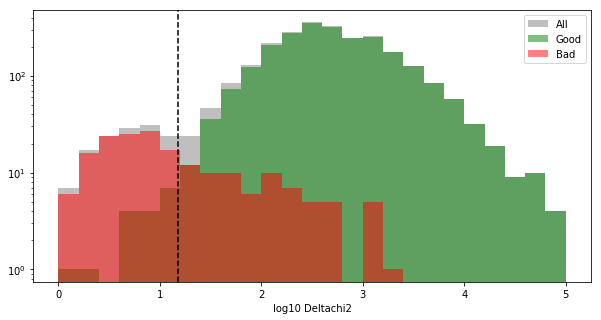

In [275]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']<=1]
#dz = abs(SV_depth_catalog['Z']-SV_depth_catalog['best_Z'])/(1.+SV_depth_catalog['best_Z'])
#selection = SV_depth_catalog[(dz<=0.0033) & (SV_depth_catalog['best_quality']>=2.5) & (SV_depth_catalog)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
print(len(np.where(bad_catalog['DELTACHI2_cas']>15)[0]))
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=20,color='b',alpha=0.3)
plt.figure(figsize=(10,5))
plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='grey',label='All')
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')

#plt.hist(np.log10(bad_1['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='b',label='Bad_1')
plt.axvline(np.log10(15),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

2718
2505
[1570    0 1570    0    0    0    0    0 1570 1570    0 1570    0    0
 1570    0    0 1570    0    0    0    0 1570 1570    0    0    0]


Text(0, 0.5, 'log10 DELTACHI2')

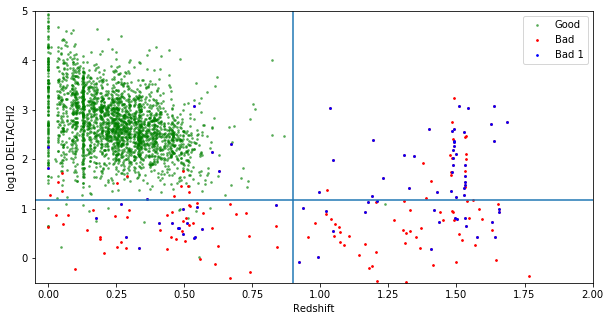

In [262]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
#plt.scatter(bad_2['Z'],np.log10(bad_2['DELTACHI2_cas']),color='orange',s=3,alpha=1,label='Bad 2')

print(len(SV_depth_catalog))
print(len(good_catalog))
print(bad_catalog[(bad_catalog['DELTACHI2_cas']>15) & (bad_catalog['Z']<0.9)]['zwarn_cas'])
#print(max(bad_catalog['DELTACHI2_cas']))
plt.legend()
plt.xlim(-0.05,2)
plt.ylim(-0.5,5)

plt.axvline(0.9)
plt.axhline(np.log10(15))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

Text(0, 0.5, 'log10 DELTACHI2')

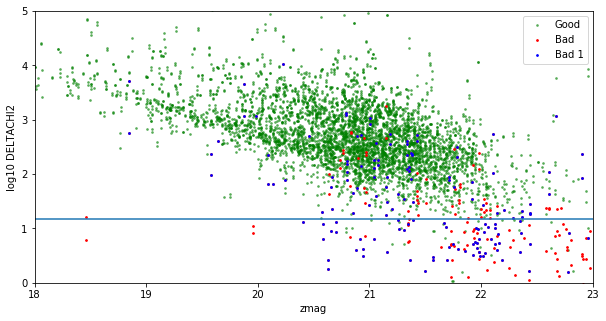

In [217]:
plt.figure(figsize=(10,5))
plt.scatter(flux_to_mag(good_catalog)['r'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(flux_to_mag(bad_catalog)['r'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(flux_to_mag(bad_1)['r'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
plt.xlim(15,25)
plt.ylim(0,5)
plt.axhline(np.log10(15))
plt.legend()
plt.xlim(18,23)
plt.ylim(0,5)

#plt.axvline(1.4)

plt.xlabel('zmag')
plt.ylabel('log10 DELTACHI2')

Text(0.5, 1.0, 'BGS 80613')

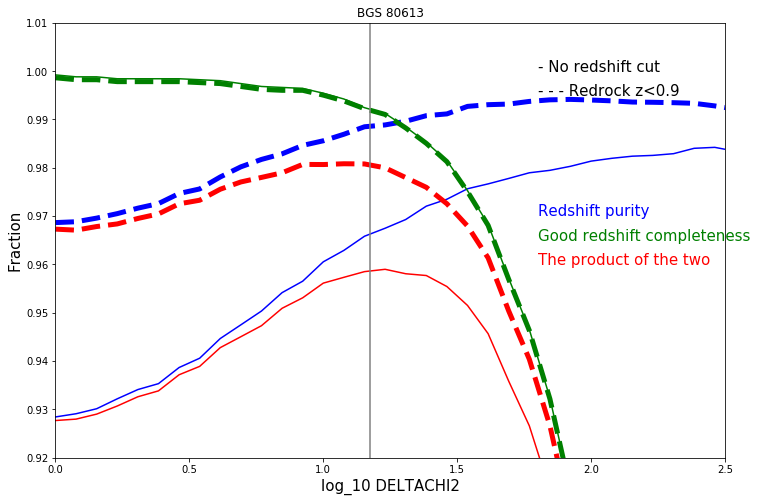

In [156]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog['DELTACHI2_cas']=SV_depth_catalog['DELTACHI2']+SV_depth_catalog['deltachi2_1']

SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['subset_id']<=2)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.92,1.01)
plt.xlim(0,2.5)
#plt.axhline(0.98,ls='--')

#SV_depth_catalog = pf.getdata(dir+dataname,1)

SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['Z']<0.9]
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--',lw=5)
plt.plot(bins,good_fraction,color='g',ls='--',lw=5)
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--',lw=5)

plt.text(1.8,1.0,'- No redshift cut',fontsize=15,color='black')
plt.text(1.8,0.995,'- - - Redrock z<0.9',fontsize=15,color='black')
plt.text(1.8,0.97,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.965,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.96,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(15),color='grey')
plt.ylabel('Fraction',fontsize=15)
plt.title('BGS 80613')

In [208]:
SV_depth_catalog = pf.getdata(dir+dataname,1)

SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']==2]
print(len(SV_depth_catalog))
out = good_robust_redrock_redshift(SV_depth_catalog)

2718


In [209]:
len(out[1][(out[1]['DELTACHI2_cas']>15) & (out[1]['Z']>0.9)])

61

In [189]:
total_good_number

5010

In [190]:
#SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog['DELTACHI2_cas']=SV_depth_catalog['DELTACHI2']+SV_depth_catalog['deltachi2_1']

#SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['subset_id']<=2)]

In [199]:
search = np.where(bad_catalog['DELTACHI2_cas']<15)
print(len(search[0]))

132


In [200]:
for i in range(0,len(search[0])):
    print(bad_catalog['TARGET_RA'][search[0][i]],bad_catalog['TARGET_DEC'][search[0][i]])

107.8623465353728 55.784172815415964
105.291853754265 56.155702906810596
105.31271335151052 56.256567766393566
104.98074446774277 56.50594450452317
105.0618112614052 56.43738692736025
105.323458454653 56.44308338679418
105.33551550145216 56.51583343937135
105.41792274656471 56.4529518890321
104.149177472165 55.63612896829832
104.5282675391658 55.63706713318856
106.76987912789959 57.17529672747828
106.78028102181908 57.28573069223097
108.28579954207191 57.42129723537518
108.22222195746521 55.78356368448972
108.37025440197009 55.844372567840644
104.49158003222908 55.44188773229085
104.67816539037216 55.48736109135051
104.83452953381956 55.594674667724455
106.60127041869112 57.652703672485046
107.10050248322534 57.66545548453861
108.17271273513592 57.01017700172555
108.42942434127123 56.88736945725554
106.36436237500062 55.722346746306286
106.56089889329344 55.640489215490724
106.65370375269433 55.73913279564658
106.96158529391704 55.83827359686838
106.01646287384092 55.000352091188354
10

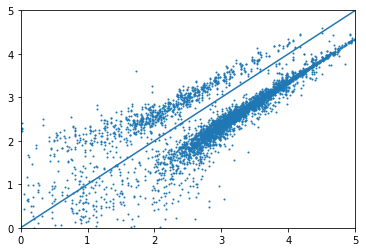

In [246]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']<=2]

plt.scatter(np.log10(SV_depth_catalog['DELTACHI2']),np.log10(SV_depth_catalog['DELTACHI2_cas']),s=1)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10))

(array([43., 35., 18., 21., 22., 37.,  2.,  0., 13.,  0.,  4.,  0.,  0.,
         0.,  1.,  4.,  0.,  0.,  3.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
         1., 31., 18., 29.]),
 array([   0.        ,  166.66666667,  333.33333333,  500.        ,
         666.66666667,  833.33333333, 1000.        , 1166.66666667,
        1333.33333333, 1500.        , 1666.66666667, 1833.33333333,
        2000.        , 2166.66666667, 2333.33333333, 2500.        ,
        2666.66666667, 2833.33333333, 3000.        , 3166.66666667,
        3333.33333333, 3500.        , 3666.66666667, 3833.33333333,
        4000.        , 4166.66666667, 4333.33333333, 4500.        ,
        4666.66666667, 4833.33333333, 5000.        ]),
 <a list of 30 Patch objects>)

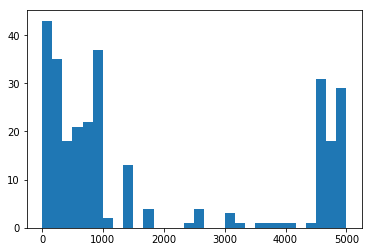

In [241]:
plt.hist(SV_depth_catalog['FIBER'][np.where(np.log10(SV_depth_catalog['DELTACHI2_cas'])-np.log10(SV_depth_catalog['DELTACHI2'])>0.5)],bins=30,range=(0,5000))

In [283]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']==2]
total_n = len(SV_depth_catalog)
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30) & (SV_depth_catalog['DELTACHI2_cas']<50) & (SV_depth_catalog['Z']<0.9)])/total_n)

0.022810890360559236
